In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', 50)

ratings = pd.read_csv('data/ratings.csv')
tags = pd.read_csv('data/tags.csv')

These timestamps aren't very useful on their own, but if we can extract the hour of the day that each rating and tag was made, this could be interesting information.  We can also make some nice histograms!

What might we infer from this?  My first idea was that this could be used to determine when users are active, allowing clustering on users that use the service at night versus in the morning versus in the afternoon.  However, these maps of user activity contradicted my initial assumptions: lots of users between the hours of 0 and 5, falling gradually to the minimum at 10.  Why are so many using the service in the middle in the night?!  The answer of course is that these timestamps are all against UTC, not the user's local timezone.  This opens an even more exciting posibility -- clustering on user activity times might allow us to cluster users by region.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc9aa139ef0>]],
      dtype=object)

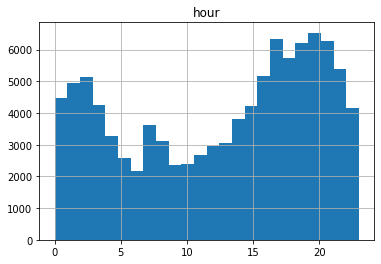

In [2]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'],unit='s')
ratings['hour'] = ratings.timestamp.dt.hour
ratings.hist(column='hour', bins=24)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc9aa01d2b0>]],
      dtype=object)

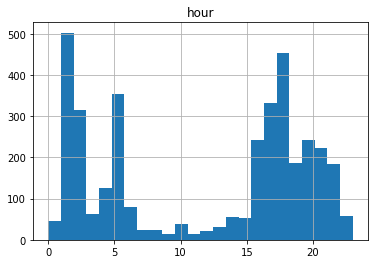

In [3]:
tags['timestamp'] = pd.to_datetime(tags['timestamp'],unit='s')
tags['hour'] = tags.timestamp.dt.hour
tags.hist(column='hour', bins=24)

Binning timestamp into hour is nice for our histograms, but we'll need to do some more work to make this usable for clustering.  It would be great if we had one-hot encodings for each hour, then could aggregate these into counts for each user.

In [4]:
# compute one-hot encodings for ratings
onehot_rating_time = pd.get_dummies(ratings['hour'], prefix='rating_time', sparse=True)
ratings = pd.concat([ratings, onehot_rating_time], axis=1)

# compute one-hot encodings for tags
onehot_tag_time = pd.get_dummies(tags['hour'], prefix='tag_time', sparse=True)
tags = pd.concat([tags, onehot_tag_time], axis=1)

Now we can sum up items created in each hour for each user.  While we're at let, let's also collect the number of ratings and number of tags produced by each user.

In [5]:
# count one-hot encoded times for ratings per user
rating_time_cols = ['userId'] + ['rating_time_' + str(i) for i in range(24)]
rating_time_counts = ratings[rating_time_cols].groupby('userId').sum()

# count one-hot encoded times for tags per user
tag_time_cols = ['userId'] + ['tag_time_' + str(i) for i in range(24)]
tag_time_counts = tags[tag_time_cols].groupby('userId').sum()

# count ratings and tags per user
rating_counts = ratings[['userId', 'rating']].groupby('userId').count()
tag_counts = tags[['userId', 'tag']].groupby('userId').count()

Now we can join all of our data to a single dataframe and take a look.  It's about what we would expect -- lots of casual users, thinning out to fewer enthusiasts, and finally a couple fanatics way off the charts.

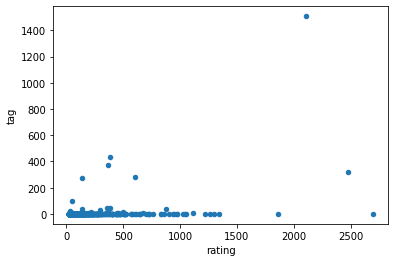

In [6]:
# join all of our counts together
users = rating_counts.join(tag_counts, on='userId').join(rating_time_counts, on='userId').join(tag_time_counts, on='userId')
# this join operation leaves users with no tags with a bunch of NaN
users = users.fillna(0)

users.plot.scatter(x='rating',y='tag')

# Clustering Users

K-means is used to cluster users into three categories.  This algorithm is good to start exploration with because it's fast and dirt simple.

Looking at the below graphic, our clustering lines up pretty closely with our intuition.  We have our casual users with dozens to a couple hundered items, enthusiasts ranging above a thousand, and finally a trickle of fanatics with by far the most ratings and tags.  While this clustering isn't very interesting, it's hard to tell if the time data we worked so hard to engineer is being used effectively.

In [7]:
kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(users)

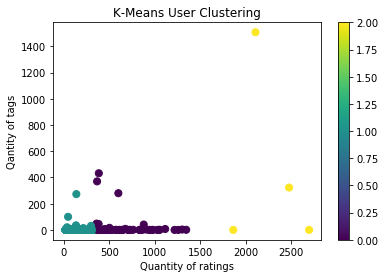

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(users['rating'], users['tag'], c=labels, s=50)
ax.set_title('K-Means User Clustering')
ax.set_xlabel('Quantity of ratings')
ax.set_ylabel('Qantity of tags')
plt.colorbar(scatter)
plt.show()

To see better see the effects of our time data, let's cut out the two most obvious axes to cluster on, number of ratings and tags and do the same clustering.

In [10]:
users_no_count = users.drop('rating', axis=1)
users_no_count = users_no_count.drop('tag', axis=1)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(users_no_count)

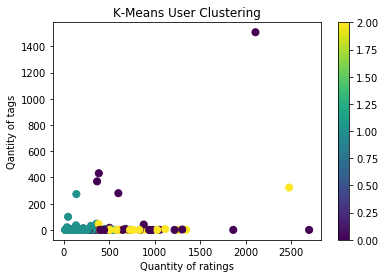

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(users['rating'], users['tag'], c=labels, s=50)
ax.set_title('K-Means User Clustering')
ax.set_xlabel('Quantity of ratings')
ax.set_ylabel('Qantity of tags')
plt.colorbar(scatter)
plt.show()

Interesting!  We can see similar, clusters forming here, even when the axes used for graphing the scatter plot aren't the ones used for clustering.  To me this is a good sign that our time-based clustering is doing something intelligible.

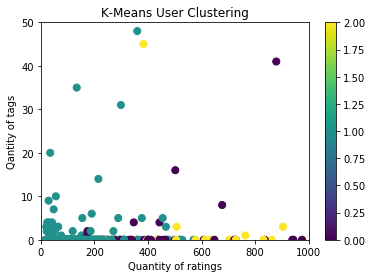

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(users['rating'], users['tag'], c=labels, s=50)
ax.set_title('K-Means User Clustering')
ax.set_xlabel('Quantity of ratings')
ax.set_xlim([0, 1000])
ax.set_ylabel('Qantity of tags')
ax.set_ylim([0, 50])
plt.colorbar(scatter)
plt.show()

# Clustering Movies

Finally, let's take a look at clustering movies.  We can use the same techniques as before, this time also computing the average 5 star rating of each movie.

Note that we're now also normalizing the vectors of each movie's rating times and tag times, such that each vector adds up to one.  This is to prevent clustering from fixating on the *quantity* of ratings, and rather look for density.  What might be the value of including this data?  Time of activity is a proxy for a number of factors: time zone, as mentioned earlier, but also age demographic, as teenage users are more likely to be active at night.  Our recommendation algorithm might benefit from providing recommendations to users of similar age or region.

In [45]:
# count one-hot encoded times for ratings per movie
rating_time_cols = ['movieId'] + ['rating_time_' + str(i) for i in range(24)]
rating_time_counts = ratings[rating_time_cols].groupby('movieId').sum()
rating_time_counts = rating_time_counts.div(rating_time_counts.sum(axis=1), axis=0)

# count one-hot encoded times for tags per movie
tag_time_cols = ['movieId'] + ['tag_time_' + str(i) for i in range(24)]
tag_time_counts = tags[tag_time_cols].groupby('movieId').sum()
tag_time_counts = tag_time_counts.div(tag_time_counts.sum(axis=1), axis=0)

# count ratings and tags per movie
movie_rating_counts = ratings[['movieId', 'rating']].groupby('movieId').count()
movie_tag_counts = tags[['movieId', 'tag']].groupby('movieId').count()

# find rating per movie
rating_overall = ratings[['movieId', 'rating']].groupby('movieId').mean()
rating_overall = rating_overall.rename(columns={'rating':'average'})

This plot of movies is interesting.  It demonstrates that average movie ratings above a certain threshold, about 4.5, are impossible for movies with more than 50 or so ratings.  Similarly, scores beneath 2 also do not appear for movies with more than 50 ratings.

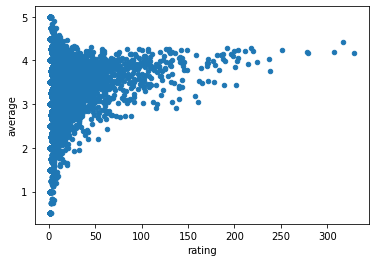

In [46]:
# join all of our counts together
movies = movie_rating_counts.join(movie_tag_counts, on='movieId').join(rating_overall, on='movieId').join(rating_time_counts, on='movieId').join(tag_time_counts, on='movieId')
# fill NaN
movies = movies.fillna(0)

movies.plot.scatter(x='rating',y='average')

Next we try clustering again with kmeans, 3 clusters.  The clustering appears to be pretty basic, focusing on the number of reviews and tags recieved by each movie.  As before, time data does not seem to come into play.  Let's see if we can improve that.

In [47]:
kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(movies)

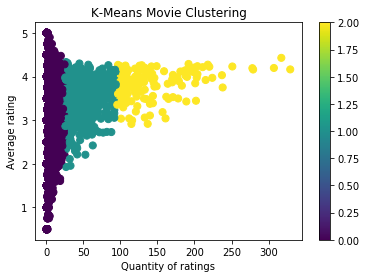

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(movies['rating'], movies['average'], c=labels, s=50)
ax.set_title('K-Means Movie Clustering')
ax.set_xlabel('Quantity of ratings')
ax.set_ylabel('Average rating')
plt.colorbar(scatter)
plt.show()

By removing the rating count, tag count, and average rating, the kmeans algorithm moves on to other means of clustering.  It is ambigous how effective this method is -- it would be interesting to cross-reference this clustering with age or timezone data to see if the clusering algorithm is in fact successfully finding these factors.

In [49]:
movies_no_count = movies.drop('rating', axis=1)
movies_no_count = movies_no_count.drop('tag', axis=1)
movies_no_count = movies_no_count.drop('average', axis=1)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(movies_no_count)

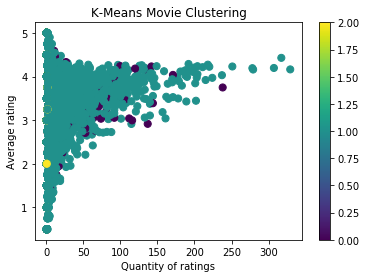

In [59]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(movies['rating'], movies['average'], c=labels, s=50)
ax.set_title('K-Means Movie Clustering')
ax.set_xlabel('Quantity of ratings')
ax.set_ylabel('Average rating')
plt.colorbar(scatter)
plt.show()